In [62]:
import tensorflow as tf
import keras as tfk
tfkl = tf.keras.layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score, ConfusionMatrixDisplay
import sys
sys.path.insert(0,'../DIGs')
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score,accuracy_score,recall_score,matthews_corrcoef,confusion_matrix,roc_curve, precision_recall_curve, auc
import seaborn as sns


# from GA_util_custom import prototype_ppms_fast

Helper functions from GA util

In [44]:

import tensorflow as tf
import keras as tfk
tfkl = tf.keras.layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tfa_spectral import SpectralNormalization as SN


nucleotides = {'A':0,'G':1,'C':2,'T':3,'a':0,'g':1,'c':2,'t':3}
letters = ['A','G','C','T']


#-----------------------------------------------    
#One Hot Encoding

# Since sequences are different lengths, this will also zero pad the shorter ones

def one_hot_encode(seqs):
    full_set = seqs.sum(axis=1).astype(str)
    seqs = full_set.apply(lambda x: pd.Series(list(x))).to_numpy()

    #seqs is shape (nseqs,seq_len)
    nseqs = seqs.shape[0]
    seq_len = seqs.shape[1]
    out = np.zeros(shape = (nseqs,4,seq_len))
    for i in range(nseqs):
        for j in range(seq_len):
            #Nan catch
            if type(seqs[i,j]) is float:
                pass
            #Catch for a typo with spaces in line 26 of the natural terminator dataset
            elif seqs[i,j] == ' ':
                seqs[i,:] = np.roll(seqs[i,:],shift=-1,axis=0)
                seqs[i,-1] = np.nan
            else:
                if seqs[i,j] == 'Z':
                    pass
                else:
                    idx = nucleotides[seqs[i,j]]
                    out[i,idx,j] = 1
    return out

#-----------------------------------------------
def prototype_ppms_fast(seqs):
    if seqs.shape[0] is None:
        return None
    else:
        output = np.zeros(shape=(seqs.shape[0],seqs.shape[2],seqs.shape[2]))
        for i in range(seqs.shape[0]):
            output[i,:,:] = contact_map(seqs[i,:,:])
        return output

#-----------------------------------------------
def contact_map(seq):
    
    #computes the structure array
    
    #seq is shape 4, nt
    seq_len = seq.shape[1]
    
    output = np.zeros(shape = (seq_len,seq_len)) #increasing dimension to 2 for G-U pair calculation
    
    gu_output = np.zeros(shape = (seq_len,seq_len))
    
    #Find the indices of each nucleotide
    As = np.where(np.argmax(seq,axis=0)==0)
    Gs = np.where(np.argmax(seq,axis=0)==1)
    Cs  = np.where(np.argmax(seq,axis=0)==2)
    Ts = np.where(np.argmax(seq,axis=0)==3)
    
    
    #Make it so now every G-C pair is represented as a 3
    output[Gs,:] = 1
    output[:,Cs]+=2
    output[output<3] = 0
    
    output[Cs,:] = 1
    output[:,Gs] +=2
    output[output<3] = 0
    
    
    #Repeat for every A-U base pair
    output[As,:] = 1
    output[:,Ts] += 1
    
    output[output< 2] = 0
    

    output[Ts,:] = 1
    output[:,As] +=1
    output[output<2] = 0
    
    #Repeat for every G-U base pair
    gu_output[Gs,:] = 1
    gu_output[:,Ts] += 1
    
    gu_output[gu_output< 2] = 0
    

    gu_output[Ts,:] = 1
    gu_output[:,Gs] +=1
    gu_output[gu_output<2] = 0
    

    
#     #Now we need to divide by the distance between the nucleotides
#     where_vals_gc = np.where(output==3)
#     where_vals_at = np.where(output==2)
    
#     #dividing base pairs by distance without for loops
#     distance_vec_gc = np.abs(where_vals_gc[0] - where_vals_gc[1])
#     # output[where_vals_gc] =1 
#     output[where_vals_gc] /= distance_vec_gc
    
#     distance_vec_at = np.abs(where_vals_at[0] - where_vals_at[1])
#     output[where_vals_at] /= distance_vec_at
    
    
#     where_vals_gu = np.where(gu_output==2)
#     distance_vec_gu = np.abs(where_vals_gu[0] - where_vals_gu[1])
#     gu_output[where_vals_gu] /= distance_vec_gu


    
    # return output,gu_output
    
    output +=gu_output
    
#     # row_sums = output.sum(axis=1)
#     # new_matrix = output / row_sums[:, np.newaxis]
#     # #Nan catch for columns with no binding partners
#     # new_matrix = np.nan_to_num(new_matrix)

    return output # Just do the binarization


def create_SANDSTORM(seq_len=60,ppm_len=60,latent_dim=128,internal_activation='relu',output_activation='linear',output_nodes=1,output_units=1,kernel_1_size=[4,18],kernel_2_size=[4,9],kernel_3_size=[4,3]):
    # seq_len is the length of the sequences
    # Latent dim controls the number of filters
    # internal activation is a tensorflow activation function, applied to the hiden layers
    # output activation is the activation function of the model output
    # output nodes is the number of different output channels the model will have (e.g. 1 for UTR prediciton, 2 for Toehold Prediction (on, off)
    # output units is the number of units in the output layer, 1 for regression problems and N for classification with N different classes 
    
    #Define the Inputs
    input_seqs = tfk.Input(shape=(4,seq_len,1))
    input_probs = tfk.Input(shape=(ppm_len,ppm_len,1))


    # Predictive Model Definition
    #Sequence Branch
    y = SN(tfkl.Conv2D(latent_dim/4, kernel_1_size, strides=(4, 1), padding="same",activation=internal_activation))(input_seqs)
    y = tfkl.BatchNormalization()(y)
    # y = layers.SpatialDropout2D(0.2)(y)
    y = SN(tfkl.Conv2D(latent_dim/8, kernel_2_size, strides=(4, 1), padding="same",activation=internal_activation))(y)
    # y = layers.BatchNormalization()(y)
    y = SN(tfkl.Conv2D(latent_dim/16,kernel_3_size,strides=(4,1),padding='same',activation=internal_activation))(y)
    # y = layers.BatchNormalization()(y)
    y = tfkl.Flatten()(y)

    #PPM Branch    
    x = SN(tfkl.Conv2D(latent_dim/4, (9,9), strides=(ppm_len, 1), padding="same",activation=internal_activation))(input_probs)
    # x = layers.BatchNormalization()(x)
    x = tfkl.SpatialDropout2D(0.2)(x)
    x = SN(tfkl.Conv2D(latent_dim/8, (5,5), strides=(ppm_len, 1), padding="same",activation=internal_activation))(x)
    # x = layers.BatchNormalization()(x)
    x = SN(tfkl.Conv2D(latent_dim/16, (3,3),strides=(ppm_len,1),padding='same',activation=internal_activation))(x)
    x = tfkl.GlobalMaxPooling2D()(x)


    x = tfkl.Flatten()(x)

    # z = CrossAttentionLayer()([x,y])


    #Combine the two
    z = tfkl.Concatenate()([x,y])
    z = tfkl.Dense(16,activation=internal_activation)(z)
    z = tfkl.Dense(8,activation=internal_activation)(z)
    z = tfkl.Dense(4,activation=internal_activation)(z)
	
    
    output_lst = []
    for i in range(output_nodes):
        tmp = tfkl.Dense(output_units,activation=output_activation,name='prediction_output_%s'%i)(z)
        output_lst.append(tmp)


    output_model  = tfk.Model(inputs=[input_seqs,input_probs],outputs=output_lst,name='joint_model')
    return output_model

def model_plot(ground_truth,predictions):
    g = sns.jointplot(x=ground_truth,y=predictions,kind='scatter')
    g.plot_joint(sns.kdeplot, color="darkblue", zorder=1, levels=6)
    g.plot_joint(sns.regplot,scatter=False,color='black')
    plt.xlabel('Measured Function')
    plt.ylabel('Predicted Function')

Explore Data

In [23]:
df = pd.read_csv("../dataset/train/train_set.csv")
df.head()

,Index,Oligo_name,Unnamed: 2,Unnamed: 3,Sequence,mfe,ires_activity,promoter_activity,splicing_score,seq,s1,s2,log,label
0,23647,no_barcode;High_Priority_Viruses_Blocks;NC_012...,no_barcode,High_Priority_Viruses_Blocks,CTAGGGCGCGCCAGTCCTAGACGAGGAATTGGAATACGGGTGGAAG...,-60.8,206.29,0.000000,NaN,AGACGAGGAATTGGAATACGGGTGGAAGAAATGGGGGAAAACATTG...,206.29,206.29,7.68853,0
1,13876,no_barcode;High_Priority_Viruses_Blocks;NC_001...,no_barcode,High_Priority_Viruses_Blocks,CTAGGGCGCGCCAGTCCTTGGTGCTAGAAGGAGATAGCTGCTTGAC...,-64.3,206.29,0.006328,NaN,TGGTGCTAGAAGGAGATAGCTGCTTGACAATCATGGCAAACGACAA...,206.29,206.29,7.68853,0
2,112,no_barcode;Human_5UTR_Screen;PRSS22;NM_022119;...,no_barcode,Human_5UTR_Screen,CTAGGGCGCGCCAGTCCTACACACCCTGACCCGCATCGCCCTGGGT...,-85.9,206.29,0.000000,NaN,ACACACCCTGACCCGCATCGCCCTGGGTCTCTCGAGCCTGCTGCCT...,206.29,206.29,7.68853,0
3,2768,no_barcode;Human_5UTR_Screen;PGRMC1;NM_006667;...,no_barcode,Human_5UTR_Screen,CTAGGGCGCGCCAGTCCTCCGGCTAGTCTTTGGCCGCCGCCGAACC...,-89.4,206.29,0.000000,NaN,CCGGCTAGTCTTTGGCCGCCGCCGAACCCCGCGCGCCACTCGCTCG...,206.29,206.29,7.68853,0
4,6625,no_barcode;High_Priority_Genes_Blocks;PPARA;NM...,no_barcode,High_Priority_Genes_Blocks,CTAGGGCGCGCCAGTCCTAGATCTACAGGGACATGTACTGAGTTCC...,-61.1,206.29,0.000000,NaN,AGATCTACAGGGACATGTACTGAGTTCCTTCAGATCAGCCACACCT...,206.29,206.29,7.68853,0


In [25]:
seqs = one_hot_encode(df[['Sequence']])

In [27]:
print(seqs[:10].shape)

(10, 4, 212)


In [28]:
ppms = prototype_ppms_fast(seqs)
print(ppms[:10].shape)

(10, 212, 212)


In [33]:
# need to convert y into binary classifications
THRESHOLD = 600
y = np.where(df['ires_activity'] >= THRESHOLD, 1, 0)
print(y[:10])
print(np.unique(y))

[0 0 0 0 0 0 0 0 0 0]
[0 1]


In [68]:
seq_train, seq_test, ppm_train, ppm_test, y_train, y_test = train_test_split(seqs, ppms, y)

In [ ]:
#parameters
LOSS = 'mse'
LR = 0.0001
EPOCHS = 300
LATENT_DIM = 64
# try larger batch sizes and latent dims (try 64)
BATCH_SIZE = 64
OUTPUT_ACT = 'sigmoid'
# INPUT_ACT = 'relu'
INTERNAL_ACT = tfkl.LeakyReLU()
ES = tfk.callbacks.EarlyStopping(patience=10,restore_best_weights=True,monitor='val_loss')
OPT = tfk.optimizers.Adam(learning_rate = LR)

In [38]:
sandstorm = create_SANDSTORM(seq_len=seqs.shape[2],
                                         ppm_len=ppms.shape[2],
                                         latent_dim=LATENT_DIM,
                                         internal_activation=INTERNAL_ACT,
                                         output_activation=OUTPUT_ACT,)

sandstorm.compile(optimizer=OPT,loss=LOSS,metrics='mse')

In [45]:
import time

time_start = time.time()
sandstorm.fit([seq_train,ppm_train],
              y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data = [[seq_test,ppm_test],y_test],
             callbacks=ES)

print(time.time()-time_start)

Epoch 1/300
1564/1564 [==============================] - 27s 16ms/step - loss: 0.1038 - mse: 0.1038 - val_loss: 0.0851 - val_mse: 0.0851
Epoch 2/300
1564/1564 [==============================] - 13s 8ms/step - loss: 0.0877 - mse: 0.0877 - val_loss: 0.0843 - val_mse: 0.0843
Epoch 3/300
1564/1564 [==============================] - 12s 8ms/step - loss: 0.0867 - mse: 0.0867 - val_loss: 0.0837 - val_mse: 0.0837
Epoch 4/300
1564/1564 [==============================] - 12s 8ms/step - loss: 0.0861 - mse: 0.0861 - val_loss: 0.0838 - val_mse: 0.0838
Epoch 5/300
1564/1564 [==============================] - 12s 7ms/step - loss: 0.0852 - mse: 0.0852 - val_loss: 0.0833 - val_mse: 0.0833
Epoch 6/300
1564/1564 [==============================] - 13s 8ms/step - loss: 0.0846 - mse: 0.0846 - val_loss: 0.0832 - val_mse: 0.0832
Epoch 7/300
1564/1564 [==============================] - 13s 8ms/step - loss: 0.0844 - mse: 0.0844 - val_loss: 0.0832 - val_mse: 0.0832
Epoch 8/300
1564/1564 [========================

In [46]:
y_preds = sandstorm.predict([seq_train, ppm_train])

391/391 [==============================] - 3s 5ms/step


In [47]:
print(y_preds)
print(np.unique(y_preds))

[[0.11290755]
 [0.0148809 ]
 [0.18952687]
 ...
 [0.14094493]
 [0.13099067]
 [0.16070028]]
[8.5352256e-04 1.0205421e-03 1.7118352e-03 ... 8.4448200e-01 8.4571040e-01
 8.6411458e-01]


391/391 [==============================] - 2s 5ms/step
r2_score is: -0.07130306017533017
spearmanr is: SignificanceResult(statistic=0.21028715567527406, pvalue=5.43954935742242e-125)
pearsonr is: PearsonRResult(statistic=0.210287155675274, pvalue=5.439549357417305e-125)


Text(37.597222222222214, 0.5, 'Predicted IRES activity (SANDSTORM)')

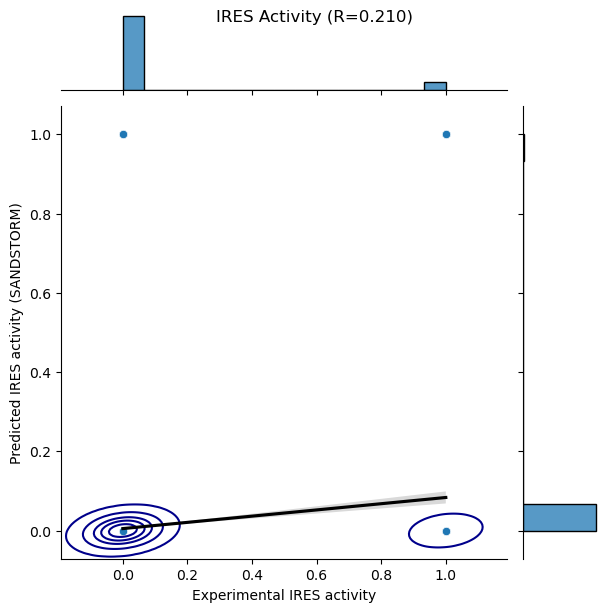

In [57]:
y_preds_score = sandstorm.predict([seq_train,ppm_train])[:,0]
y_preds = np.where(y_preds_score >= 0.5, 1, 0)
r = spearmanr(y_train,y_preds)

print('r2_score is:',r2_score(y_train,y_preds))
print('spearmanr is:',spearmanr(y_train,y_preds))
print('pearsonr is:',pearsonr(y_train,y_preds))

# plt.figure(figsize=[6,4])
# plt.scatter(y_test[:,0],y_preds,alpha=0.1)
model_plot(y_train,y_preds)
plt.suptitle('IRES Activity (R=%.3f)'%r[0])
# plt.suptitle('')
plt.xlabel('Experimental IRES activity')
plt.ylabel('Predicted IRES activity (SANDSTORM)')

In [ ]:
y_train_binary = np.where(y_train >= 0.5, 1, 0)

In [63]:
# evaluation on our data...
acc = accuracy_score(y_train_binary, y_preds)
sn = recall_score(y_train_binary, y_preds)
mcc = matthews_corrcoef(y_train_binary, y_preds)
c_matrix = confusion_matrix(y_train_binary, y_preds)
print(c_matrix)
tn, fp, fn, tp = c_matrix.ravel()
sp = tn / (tn + fp)
auroc = roc_auc_score(y_train_binary, y_preds_score)
f1 = f1_score(y_train_binary, y_preds.reshape(-1))
lr_precision, lr_recall, _ = precision_recall_curve(y_train_binary, y_preds_score)
aupr=auc(lr_recall,lr_precision)

print("ACC : ", acc)
print("SN : ", sn)
print("SP : ", sp)
print("MCC : ", mcc)
print("AUC : ", auroc)
print("F1-sorce : ", f1)
print("AUPR : ", aupr)

[[11143    56]
 [ 1197   109]]
ACC :  0.8998000799680128
SN :  0.08346094946401225
SP :  0.9949995535315653
MCC :  0.2102871556752741
AUC :  0.7443248255457069
F1-sorce :  0.14819850441876276
AUPR :  0.33410895979381916


In [64]:
print(c_matrix.shape)

(2, 2)


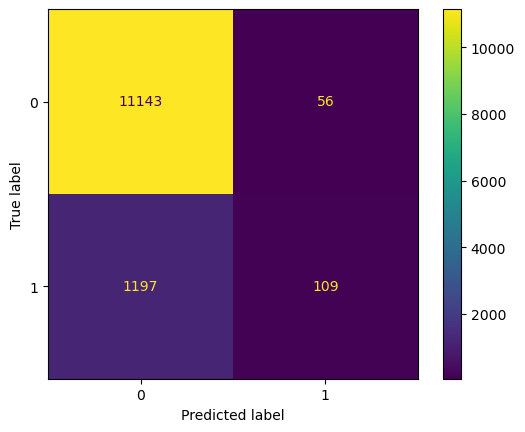

In [65]:
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
disp.plot()
plt.show()

131/131 [==============================] - 1s 5ms/step
(4169,)
(4169,)
r2_score is: -0.06308566756856693
spearmanr is: SignificanceResult(statistic=0.21957407054521333, pvalue=1.0869582286763623e-46)
pearsonr is: PearsonRResult(statistic=0.21957407054521325, pvalue=1.0869582286765414e-46)


Text(37.597222222222214, 0.5, 'Predicted IRES activity (SANDSTORM)')

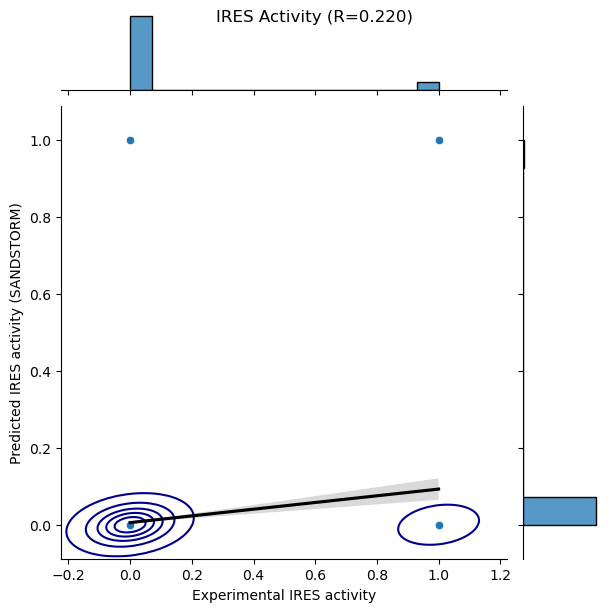

In [69]:
y_preds_test_score = sandstorm.predict([seq_test,ppm_test])[:,0]
y_preds_test = np.where(y_preds_test_score >= 0.5, 1, 0)
print(y_preds_test.shape)
print(y_test.shape)
r = spearmanr(y_test,y_preds_test)

print('r2_score is:',r2_score(y_test,y_preds_test))
print('spearmanr is:',spearmanr(y_test,y_preds_test))
print('pearsonr is:',pearsonr(y_test,y_preds_test))

# plt.figure(figsize=[6,4])
# plt.scatter(y_test[:,0],y_preds,alpha=0.1)
model_plot(y_test,y_preds_test)
plt.suptitle('IRES Activity (R=%.3f)'%r[0])
# plt.suptitle('')
plt.xlabel('Experimental IRES activity')
plt.ylabel('Predicted IRES activity (SANDSTORM)')

In [70]:
# evaluation on our data...
acc = accuracy_score(y_test, y_preds_test)
sn = recall_score(y_test, y_preds_test)
mcc = matthews_corrcoef(y_test, y_preds_test)
c_matrix = confusion_matrix(y_test, y_preds_test)
print(c_matrix)
tn, fp, fn, tp = c_matrix.ravel()
sp = tn / (tn + fp)
auroc = roc_auc_score(y_test, y_preds_test_score)
f1 = f1_score(y_test, y_preds_test.reshape(-1))
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_preds_test_score)
aupr=auc(lr_recall,lr_precision)

print("ACC : ", acc)
print("SN : ", sn)
print("SP : ", sp)
print("MCC : ", mcc)
print("AUC : ", auroc)
print("F1-sorce : ", f1)
print("AUPR : ", aupr)

[[3738   21]
 [ 372   38]]
ACC :  0.9057327896378028
SN :  0.09268292682926829
SP :  0.994413407821229
MCC :  0.21957407054521327
AUC :  0.7607900388660709
F1-sorce :  0.16204690831556504
AUPR :  0.34539046225579945


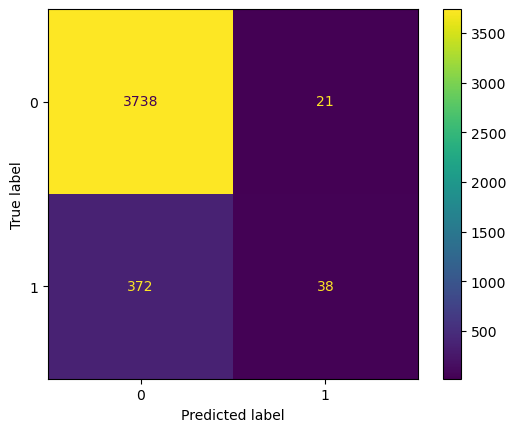

In [71]:
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
disp.plot()
plt.show()

Testing Sandstorm tested on our data split

In [ ]:
# get the dataset we are teesting
active_df = pd.read_csv('../dataset/external_testing_dataset/Human_5UTR_HMM_ires_activity.csv')
print(active_df.head)
print(active_df.shape)

<bound method NDFrame.head of      Unnamed: 0  Index                                         Oligo_name  \
0            20     21  no_barcode;Human_5UTR_Screen;NDUFC1;NM_0011849...   
1            26     27  no_barcode;Human_5UTR_Screen;MAGEA8;NM_0011664...   
2            32     33  no_barcode;Human_5UTR_Screen;SSR4;NM_006280;12...   
3            38     39  no_barcode;Human_5UTR_Screen;RPL32;NM_00100707...   
4            41     42  no_barcode;Human_5UTR_Screen;B4GALT3;NM_003779...   
..          ...    ...                                                ...   
654       29680  29681  8nt_barcode;Human_5UTR_Screen;AGTRAP;NM_001040...   
655       29709  29710  8nt_barcode;Human_5UTR_Screen;CHI3L2;NM_001025...   
656       29716  29717  8nt_barcode;Human_5UTR_Screen;ZNF250;NM_021061...   
657       29943  29944  8nt_barcode;Human_5UTR_Screen;TMCO1;NM_0012561...   
658       29974  29975  8nt_barcode;Human_5UTR_Screen;ANXA2;NM_0010028...   

                                             

In [77]:
seqs = one_hot_encode(active_df[['Sequence']])
print(seqs.shape)
ppms = prototype_ppms_fast(seqs)
y = np.where(active_df['ires_activity'] > THRESHOLD, 1, 0)

(659, 4, 212)


21/21 [==============================] - 0s 5ms/step
[[106   3]
 [539  11]]
ACC :  0.17754172989377845
SN :  0.02
SP :  0.9724770642201835
MCC :  -0.019383762189576745
AUC :  0.5213844870725605
F1-sorce :  0.03900709219858156
AUPR :  0.8344418520693082


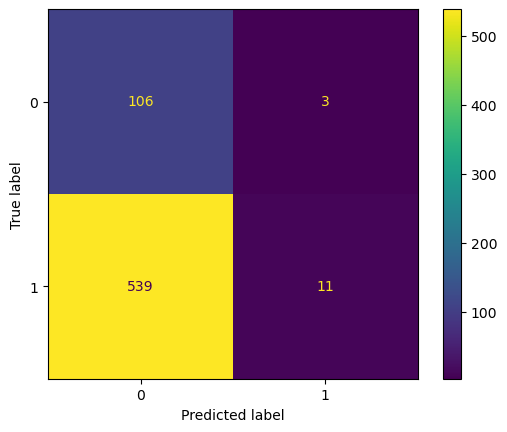

In [79]:
# evaluation on our data...
y_active_score = sandstorm.predict([seqs,ppms])[:,0]
y_active = np.where(y_active_score >= 0.5, 1, 0)

acc = accuracy_score(y, y_active)
sn = recall_score(y, y_active)
mcc = matthews_corrcoef(y, y_active)
c_matrix = confusion_matrix(y, y_active)
print(c_matrix)
tn, fp, fn, tp = c_matrix.ravel()
sp = tn / (tn + fp)
auroc = roc_auc_score(y, y_active_score)
f1 = f1_score(y, y_active.reshape(-1))
lr_precision, lr_recall, _ = precision_recall_curve(y, y_active_score)
aupr=auc(lr_recall,lr_precision)

print("ACC : ", acc)
print("SN : ", sn)
print("SP : ", sp)
print("MCC : ", mcc)
print("AUC : ", auroc)
print("F1-sorce : ", f1)
print("AUPR : ", aupr)

disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
disp.plot()
plt.show()